# Fit multiple potential SNIa with `sncosmo`

Import packages.

In [1]:
import sncosmo
import iminuit
import numpy as np

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Define the  model for `sncosmo`.

In [2]:
model = sncosmo.Model(source='salt2')

Read in the nightly epoch lightcurves for all "good" candidates from 2021.

In [3]:
path = '../extragalactic_fields/candidate_nightly_epochs_files/'
fnm = path + 'candidate_lightcurves.dat'
candLC_field   = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid  = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd     = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter  = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj    = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag     = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage    = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb     = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_maglim  = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

Read in the list of candidate IDs for potential SNIa that Melissa made with the MLG_snia_menagerie.ipynb notebook.

In [4]:
path = '../extragalactic_fields/science_with_candidates/MLG_snia_menagerie_files/'
fnm = path + 'potential_snia_list.dat'
potSNIa_candid = np.loadtxt(fnm, dtype='str', usecols=(0))
del fnm

In [5]:
# print(potSNIa_candid)

Define arrays to hold their fit results.

In [6]:
fit_z   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ze  = np.zeros(len(potSNIa_candid), dtype='float') 
fit_t0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_t0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1e = np.zeros(len(potSNIa_candid), dtype='float')
fit_c   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ce  = np.zeros(len(potSNIa_candid), dtype='float')

Run `sncosmo` for just 5 of the potential SNIa for now.

In [7]:
for c in range(5):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')
    
    # do the fit like the example with sncosmo
    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':(0.3, 0.7)})
    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']
    

See how the results arrays are populated.

In [8]:
print(fit_z)

[0.41130085 0.50496126 0.32988932 0.55752008 0.50659747 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


Yup OK, looks like the basic process above is going to work OK.

**TO DO!!**

Add a step to the fitting process abobe that involves estimating the likely redshift range for the SNIa from its peak brightness, and then using that smaller range for the boundaries in the `sncosmo.fit_lc()` command.

Then do the fit for ALL the potential SNIa, not just 5.

Then, explore their results. You can make plots of the distributions of values, compare relations between values, look at which potential SNIa have big errors. 

**UPDATE**

When collecting DDF data, we don't always capture the peak brightness of the SNe (e.g. just the decline). This thus underestimates the peak and affects the estimated redshift we initially wanted to calculate. Taking this into consideration, we will no longer be estimating the likely redshift range for each candidate using their peak brightnesses, but rather using a fixed range, z = 0.05 to z = 0.5. 
___

## Running `sncosmo` for all potential SNIa candidates

In [9]:
# Check number of potential candidates
len(potSNIa_candid)

51

#### Run `sncosmo` (with fixed redshift range)

In [10]:
for c in range(len(potSNIa_candid)):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')
    
    # estimate z_range specific to each SNIa
    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

    z_range_offset = 0.1
    z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)
    
    # do the fit like the example with sncosmo
    try:
        result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':z_range})
    except Exception:
        result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':(0.05,0.5)})

    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']

Check that the result arrays are fully populated

In [11]:
fit_z

array([0.41144347, 0.23536018, 0.13827851, 0.34260627, 0.24944336,
       0.26394978, 0.25646641, 0.19715072, 0.10189526, 0.2351775 ,
       0.19073545, 0.02083056, 0.32824266, 0.38574378, 0.35182224,
       0.09551352, 0.1402021 , 0.36381669, 0.33598847, 0.31366042,
       0.2808495 , 0.08276723, 0.20185453, 0.15821222, 0.2411725 ,
       0.3250767 , 0.20421982, 0.16728635, 0.12394699, 0.43141822,
       0.3004764 , 0.1192966 , 0.11491502, 0.23119074, 0.3350877 ,
       0.3455379 , 0.31665535, 0.334936  , 0.37216233, 0.26800714,
       0.40112015, 0.18078686, 0.25528496, 0.3768357 , 0.40326192,
       0.34435415, 0.18732723, 0.37601091, 0.54304642, 0.12701118,
       0.22209336])

## Analyzing the results

In [12]:
import matplotlib.pyplot as plt

### Looking at the fit parameter distributions

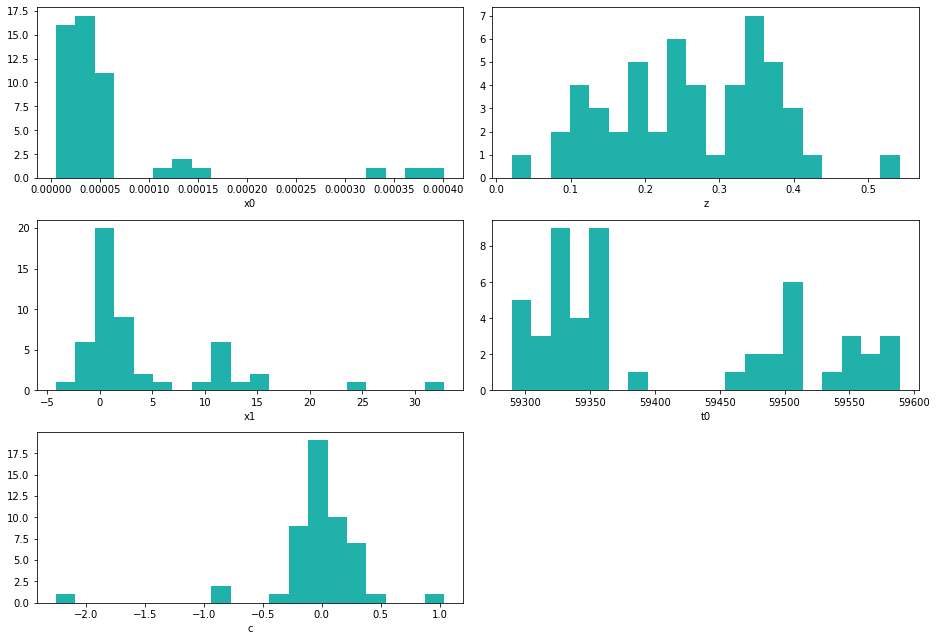

In [13]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,0].set_xlabel('x0')

ax[0,1].hist(fit_z, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,1].set_xlabel('z')

ax[1,0].hist(fit_x1, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,0].set_xlabel('x1')

ax[1,1].hist(fit_t0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,1].set_xlabel('t0')

ax[2,0].hist(fit_c, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[2,0].set_xlabel('c')

fig.tight_layout()
fig.show()

Each fit parameter (x0, x1, & c) seems to have a general range for values. All these SN Ia have redshift z<~0.5

Outliers in each of these plots above could be indications of bad fits to type 1a supernovae? Let's look at the fitted plots for these candidates with such odd parameter values.

### Looking at the fits of candidates with outlying parameter values

In [14]:
# Find candidates associated w/ outlying x0 values
np.where(fit_x0 > 0.00025)

(array([ 2, 26, 32]),)

In [15]:
# Find candidates associated w/ outlying x1 values
np.where(fit_x1 > 20)

(array([21, 37]),)

In [16]:
# Find candidates associated w/ outlying c values
np.where(fit_c < -2.0)

(array([2]),)

In [17]:
# Find candidates associated w/ outlying z values
np.where(fit_z > 0.45)

(array([48]),)

#### Candidate 2

135


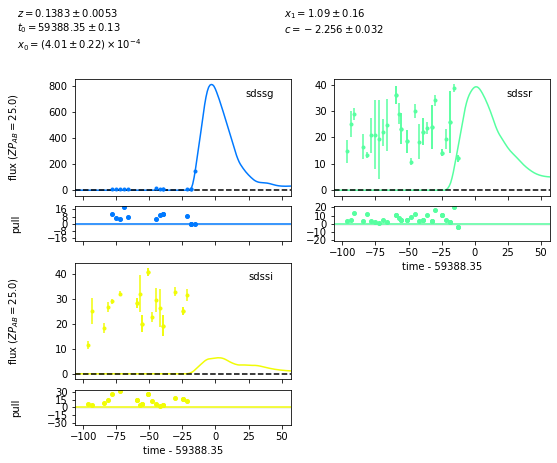

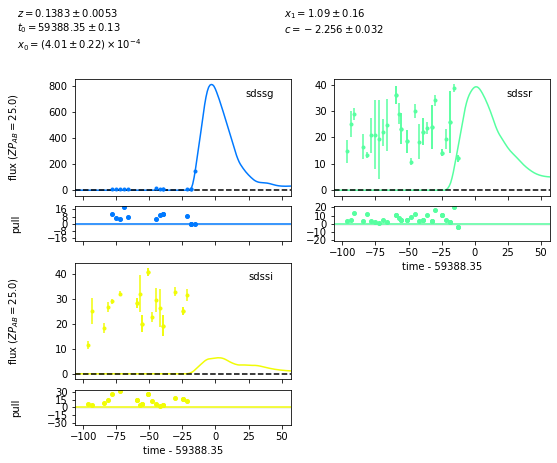

In [18]:
my_potential_snia = (potSNIa_candid[2])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

# read the file with sncosmo
data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 21

135


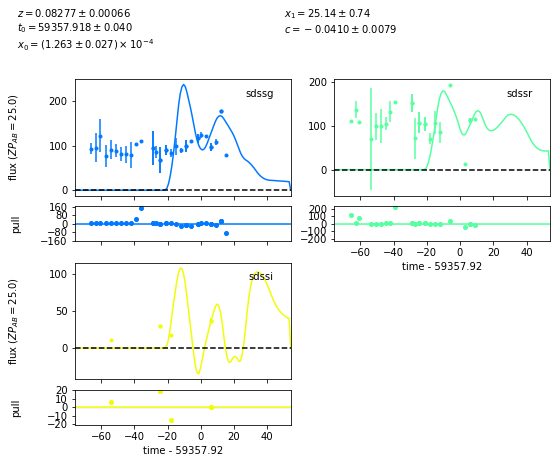

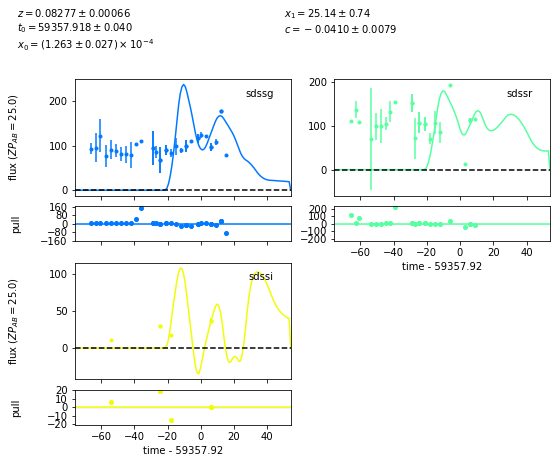

In [19]:
my_potential_snia = (potSNIa_candid[21])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

# read the file with sncosmo
data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 26

135


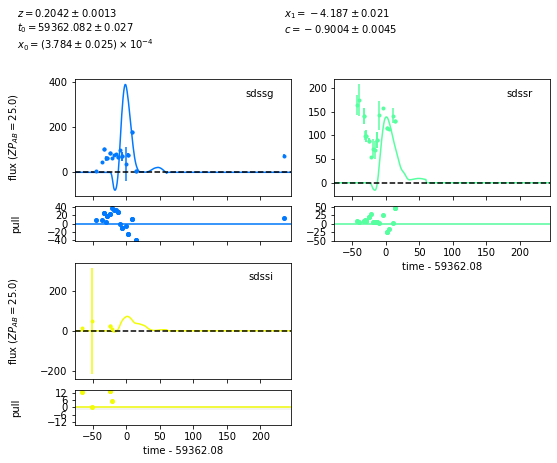

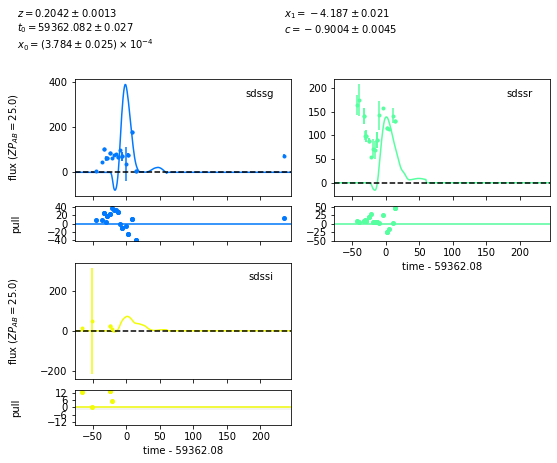

In [20]:
my_potential_snia = (potSNIa_candid[26])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

# read the file with sncosmo
data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 32

117


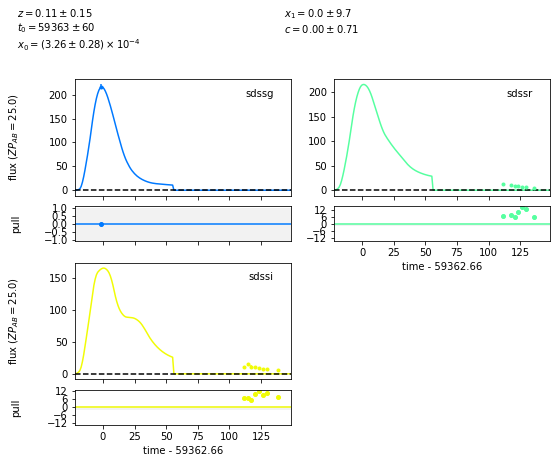

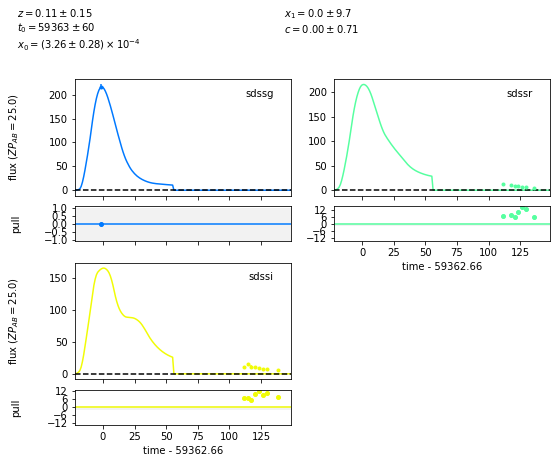

In [21]:
my_potential_snia = (potSNIa_candid[32])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

# read the file with sncosmo
data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 37

117


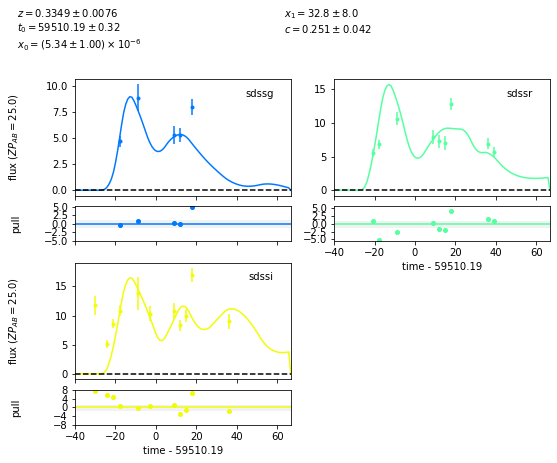

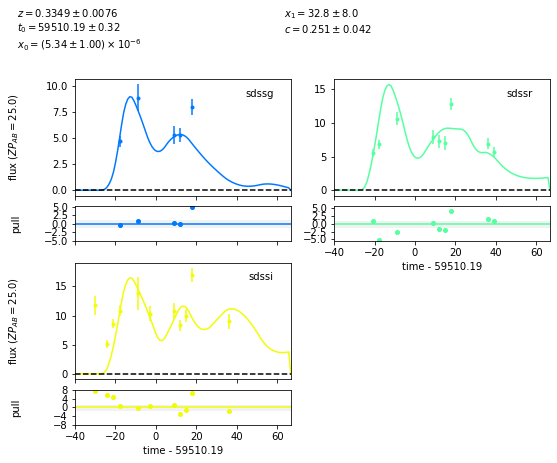

In [22]:
my_potential_snia = (potSNIa_candid[37])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

# read the file with sncosmo
data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 48

117


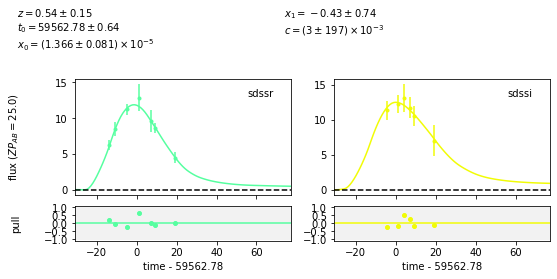

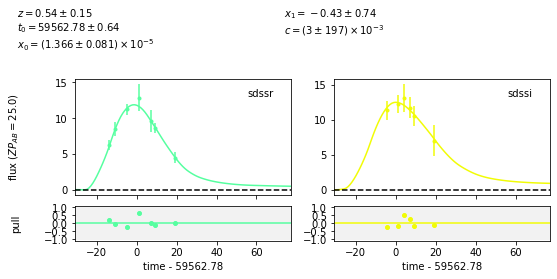

In [23]:
my_potential_snia = (potSNIa_candid[48])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

# read the file with sncosmo
data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

### Looking at the fit parameter error distributions

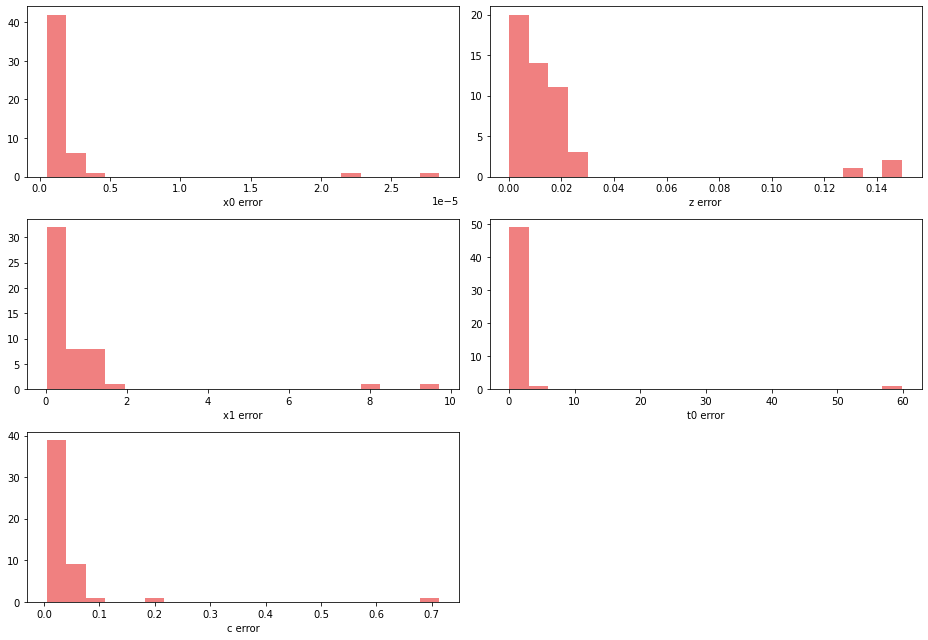

In [24]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0,0].set_xlabel('x0 error')

ax[0,1].hist(fit_ze, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0,1].set_xlabel('z error')

ax[1,0].hist(fit_x1e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1,0].set_xlabel('x1 error')

ax[1,1].hist(fit_t0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1,1].set_xlabel('t0 error')

ax[2,0].hist(fit_ce, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[2,0].set_xlabel('c error')

fig.tight_layout()
fig.show()

Of course, we usually want to have the errors of our values pretty small, and the majority of our errors lie close to 0. That can indicate our values are pretty accurate. However, there are exceptions?

### Looking at the fits of candidates with large errors in parameters

Similarly as I did with candidates that have outlying parameter values, I will look at the fits of candidates that have large errors.

In [25]:
# Find candidates associated with large x0 bounds
np.where(fit_x0e > 2.0e-5)

(array([ 2, 32]),)

In [26]:
# Find candidates associated with large x1 bounds
np.where(fit_x1e > 6)

(array([32, 37]),)

In [27]:
# Find candidates associated with large c bounds
np.where(fit_ce > 0.15)

(array([32, 48]),)

In [28]:
# Find candidates associated with large z bounds
np.where(fit_ze > 0.1)

(array([32, 34, 48]),)

In [29]:
# Find candidates associated with large t0 bounds
np.where(fit_t0e > 50)

(array([32]),)

#### Candidate 34

117


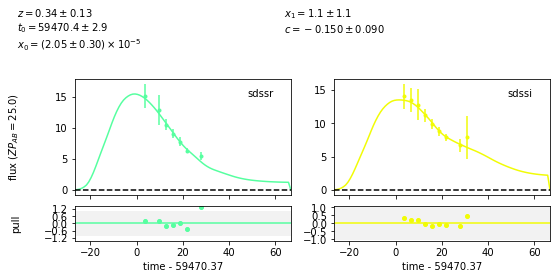

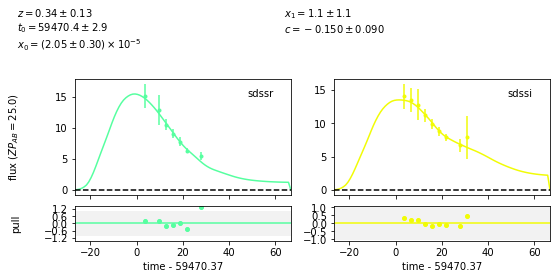

In [30]:
my_potential_snia = (potSNIa_candid[34])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

# read the file with sncosmo
data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

This candidate only has large z error, and the fit looks decent. Can note that this candidate looks to have only detected the decline, so peak brightness is underestimated, which affects estimated redshift we calculated for the redshift bounds.

### Comparing relations between values

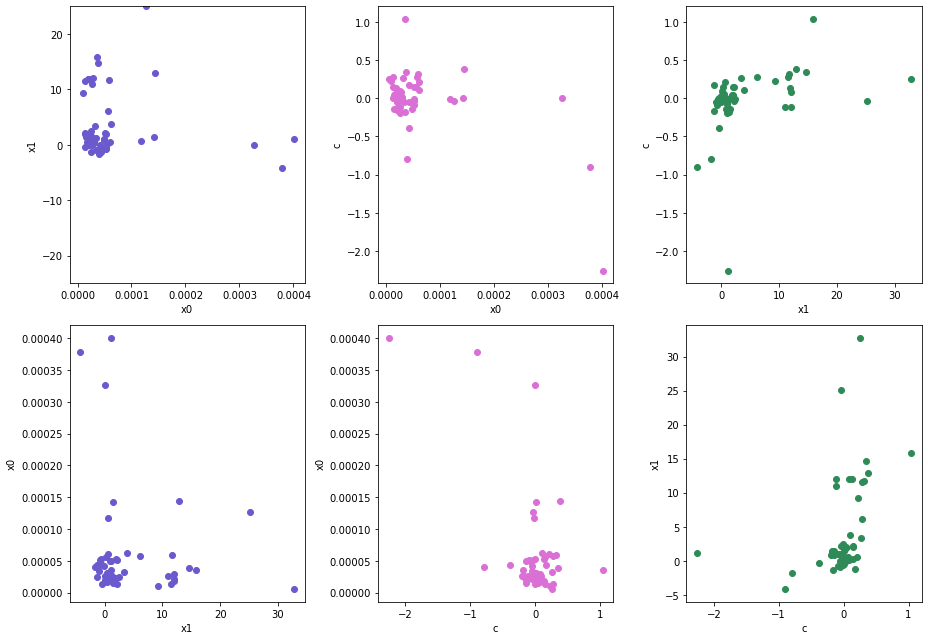

In [31]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(fit_x0, fit_x1, color='slateblue')
ax[0,0].set_ylim([-25,25])
ax[0,0].set_xlabel('x0')
ax[0,0].set_ylabel('x1')

ax[0,1].scatter(fit_x0, fit_c, color='orchid')
ax[0,1].set_xlabel('x0')
ax[0,1].set_ylabel('c')

ax[0,2].scatter(fit_x1, fit_c, color='seagreen')
ax[0,2].set_xlabel('x1')
ax[0,2].set_ylabel('c')

ax[1,0].scatter(fit_x1, fit_x0, color='slateblue')
ax[1,0].set_xlabel('x1')
ax[1,0].set_ylabel('x0')

ax[1,1].scatter(fit_c, fit_x0, color='orchid')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel('x0')

ax[1,2].scatter(fit_c, fit_x1, color='seagreen')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel('x1')


fig.tight_layout()
fig.show()

## Reanalyzing results w/ parameter *bounds*

Using bounds shown in the parameter distributions from papers <a href="https://academic.oup.com/mnras/article/504/3/4111/6225808"> here </a> and <a href="https://arxiv.org/abs/1401.4065"> here

### Looking at *bounded* fit parameter distributions

In [92]:
for c in range(len(potSNIa_candid)):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')

    # estimate z_range specific to each SNIa
    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

    z_range_offset = 0.1
    z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)
    
    # do the fit like the example with sncosmo
    try:
        result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
    except Exception:
        result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':(0.05,0.5),'x1':(-3,3),'c':(-0.3,0.3)})

    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']

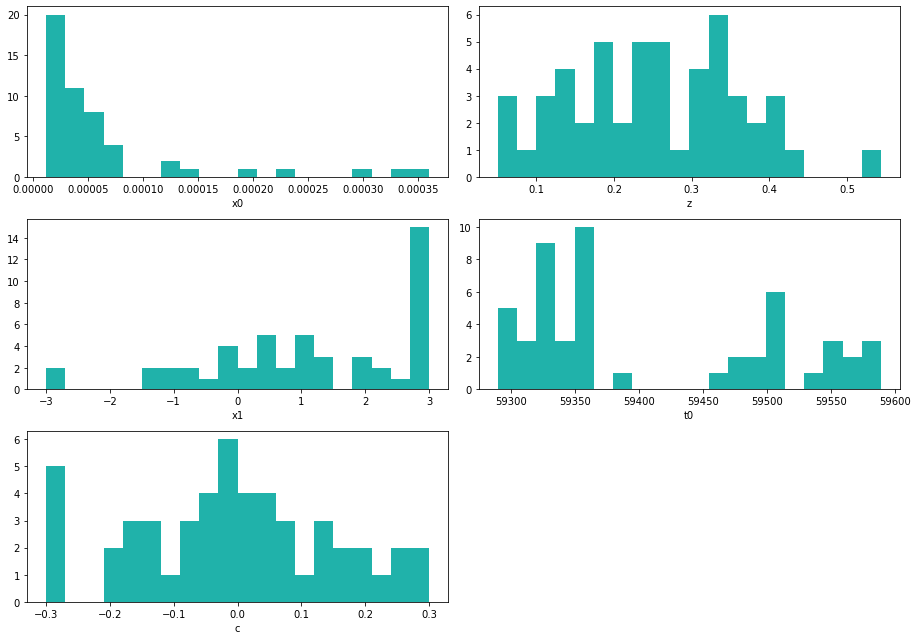

In [93]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,0].set_xlabel('x0')

ax[0,1].hist(fit_z, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,1].set_xlabel('z')

ax[1,0].hist(fit_x1, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,0].set_xlabel('x1')

ax[1,1].hist(fit_t0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,1].set_xlabel('t0')

ax[2,0].hist(fit_c, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[2,0].set_xlabel('c')

fig.tight_layout()
fig.show()

### Looking at *bounded* fits of candidates with outlying parameter values

In [94]:
# Candidates associated with outlying x0 values
np.where(fit_x0 > 0.00025)

(array([21, 26, 32]),)

In [95]:
# Candidates associated with outlying x1 values
np.where(fit_x1 < -2)

(array([ 2, 26]),)

In [96]:
# Candidates associated w/ outlying z values
np.where(fit_z > 0.5)

(array([48]),)

All these candidates were detected earlier, when running sncosmo w/out x1 & c bounds.

#### Candidate 2

135


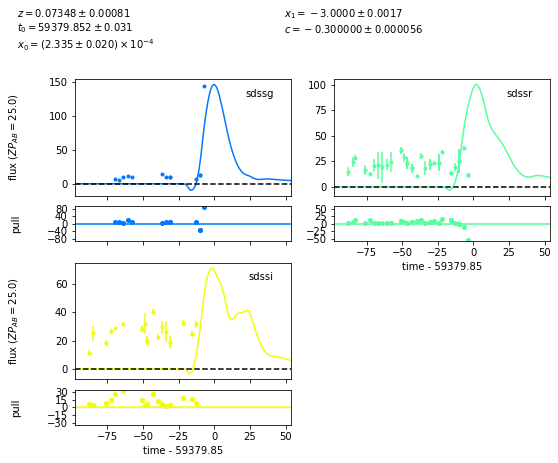

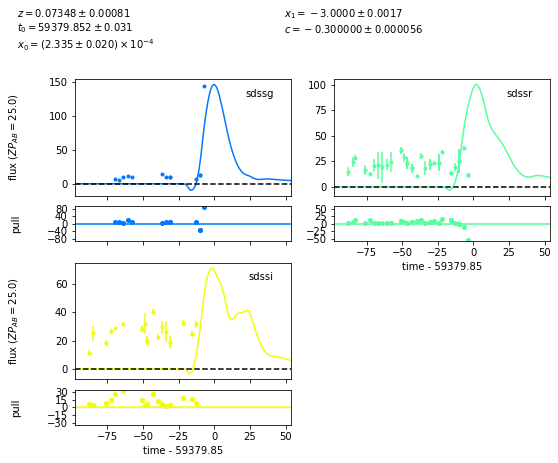

In [97]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[2])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5),'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 21

135


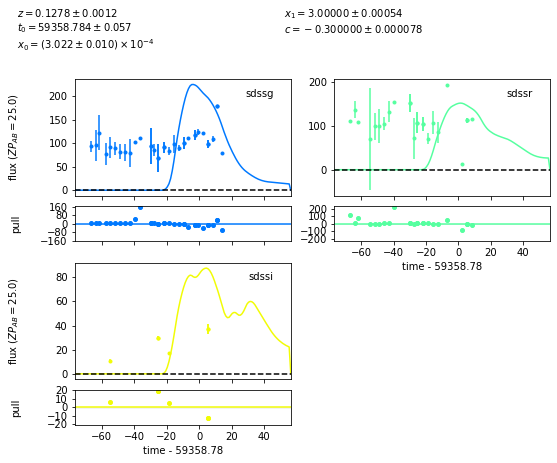

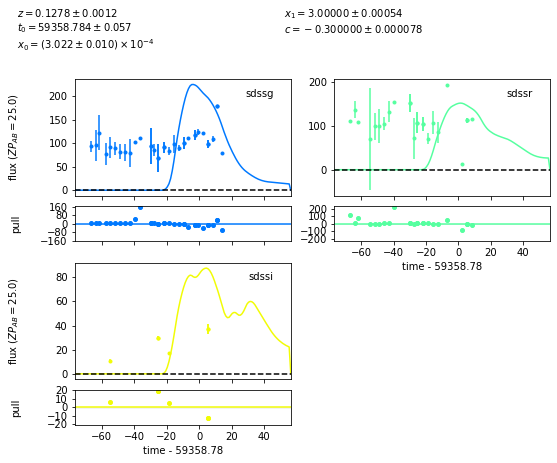

In [98]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[21])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5),'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 26

135


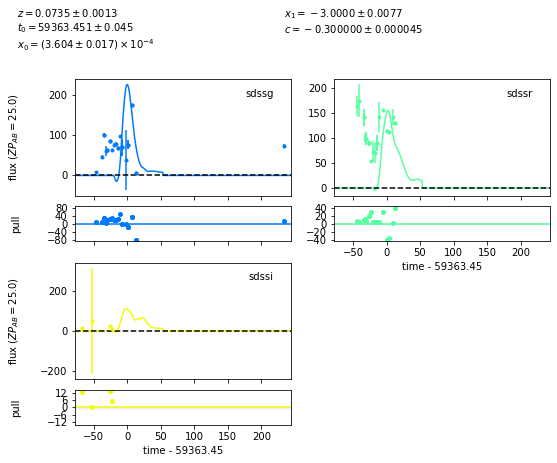

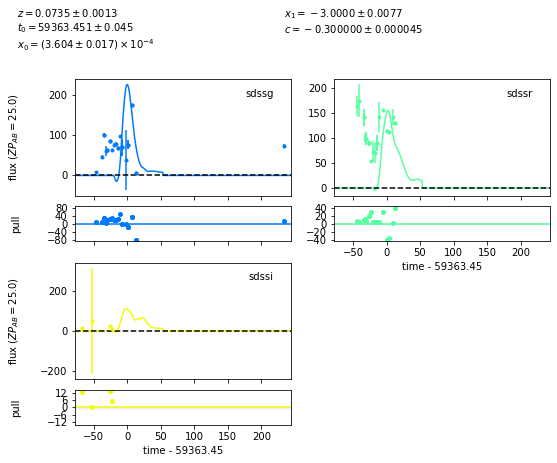

In [99]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[26])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5),'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 32

117


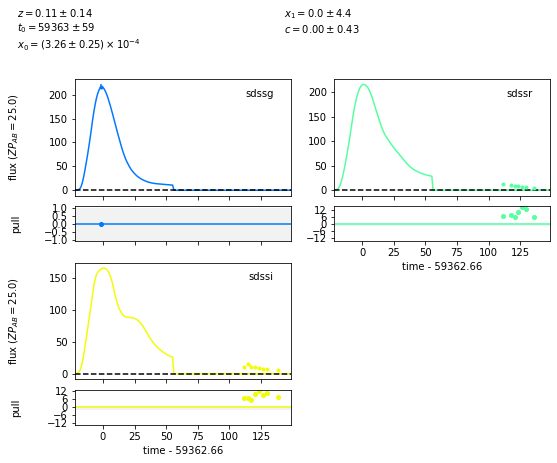

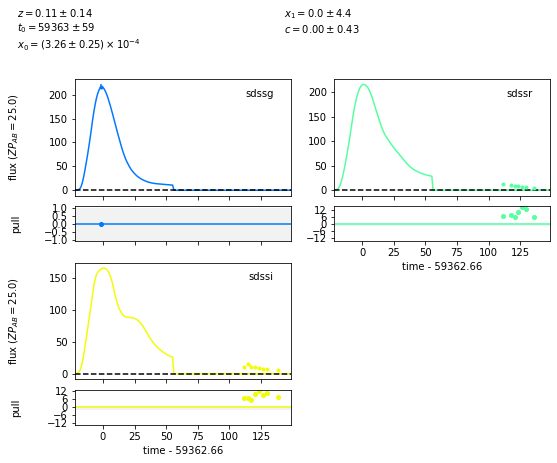

In [100]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[32])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5),'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 48

117


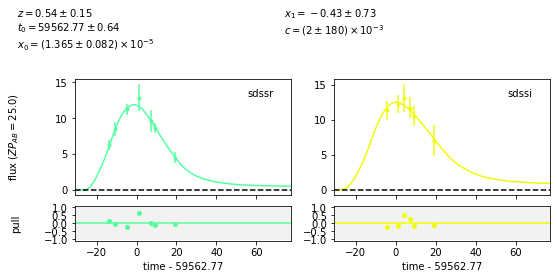

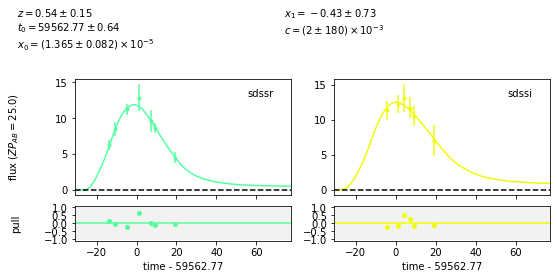

In [101]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[48])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5),'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

W/out additional bounds, candidate 43 had many bumps and min/max in its fit, which would never occur in a real SNIa. Now, candidate 43 has just one maximum. Candidate 2, however, doesn't look much better from before.

Now that we have better bounds on our parameters, we can be more confident in seeing fits that failed due to actual non-SNIa, or poor data.

### Looking at *bounded* fit parameter error distributions

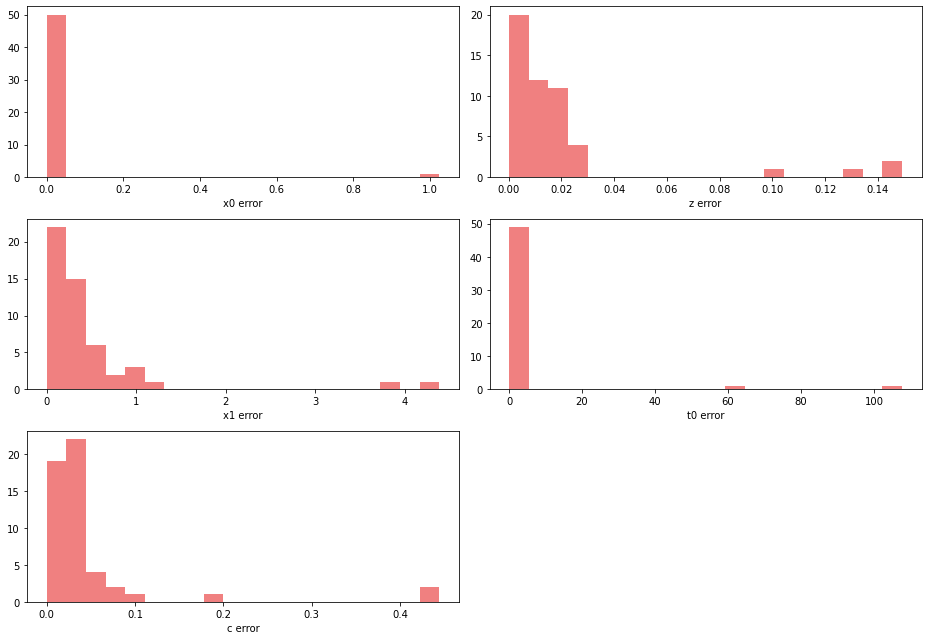

In [102]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0,0].set_xlabel('x0 error')

ax[0,1].hist(fit_ze, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0,1].set_xlabel('z error')

ax[1,0].hist(fit_x1e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1,0].set_xlabel('x1 error')

ax[1,1].hist(fit_t0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1,1].set_xlabel('t0 error')

ax[2,0].hist(fit_ce, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[2,0].set_xlabel('c error')

fig.tight_layout()
fig.show()

### Looking at *bounded* fits of candidates with large error in parameters

In [103]:
# Candidates associated with large x0 errors
np.where(fit_x0e > 0.8)

(array([41]),)

In [104]:
# Candidates associated with large x1 errors
np.where(fit_x1e > 3)

(array([32, 41]),)

In [105]:
# Candidates associated with large c errors
np.where(fit_ce > 0.15)

(array([32, 41, 48]),)

In [106]:
# Candidates associated with large z errors
np.where(fit_ze > 0.08)

(array([32, 34, 41, 48]),)

In [107]:
# Candidates associated with large t0 errors
np.where(fit_t0e > 40)

(array([32, 41]),)

So we already detected index 32 & 48. Candidates associated w/ index 34 & 41 are new.

#### Candidate 34

117


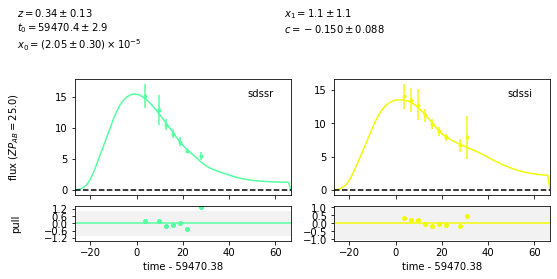

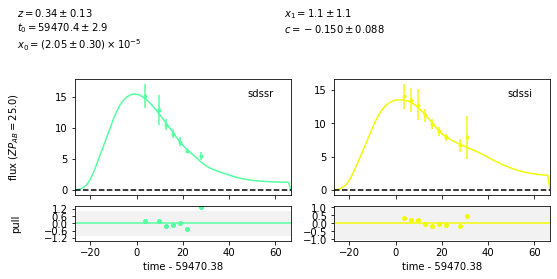

In [108]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[34])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5),'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 41

117


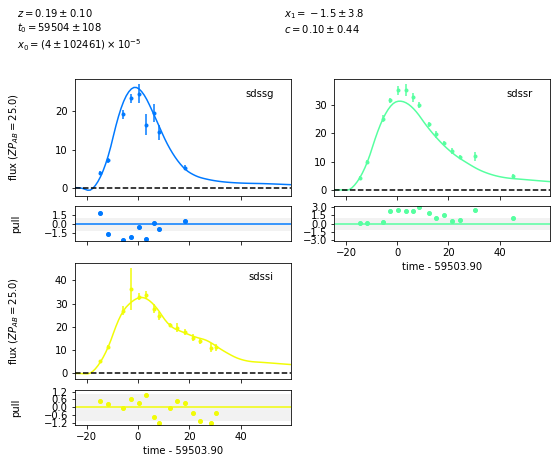

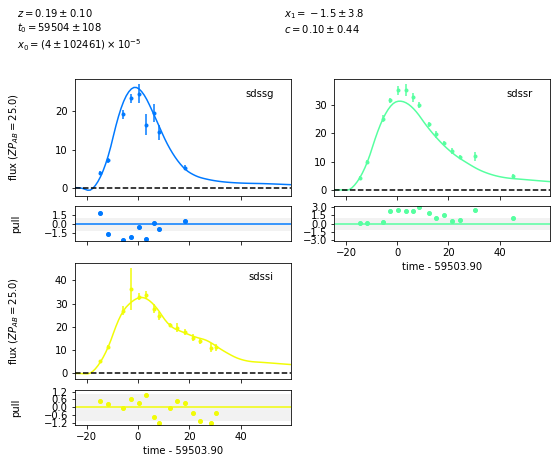

In [109]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[41])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)

# do the fit like the example with sncosmo
try:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
except Exception:
    result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':(0.05,0.5),'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

### Removing bad fits

Not deleting index 41 b/c actual data looks good. The fit is just not working well for some reason. Also not deleting index 48 because it could be real, but bad fit parameters due to no detection in g-band.

In [110]:
new_fit_x0 = np.delete(fit_x0, [2,21,26,32,34,41], 0)
new_fit_x0e = np.delete(fit_x0e, [2,21,26,32,34,41], 0)

new_fit_x1 = np.delete(fit_x1, [2,21,26,32,34,41], 0)
new_fit_x1e = np.delete(fit_x1e, [2,21,26,32,34,41], 0)

new_fit_c = np.delete(fit_c, [2,21,26,32,34,41], 0)
new_fit_ce = np.delete(fit_ce, [2,21,26,32,34,41], 0)

new_fit_z = np.delete(fit_z, [2,21,26,32,34,41], 0)
new_fit_ze = np.delete(fit_ze, [2,21,26,32,34,41], 0)

new_fit_t0 = np.delete(fit_t0, [2,21,26,32,34,41], 0)
new_fit_t0e = np.delete(fit_t0e, [2,21,26,32,34,41], 0)

## Re-Comparing relations between values

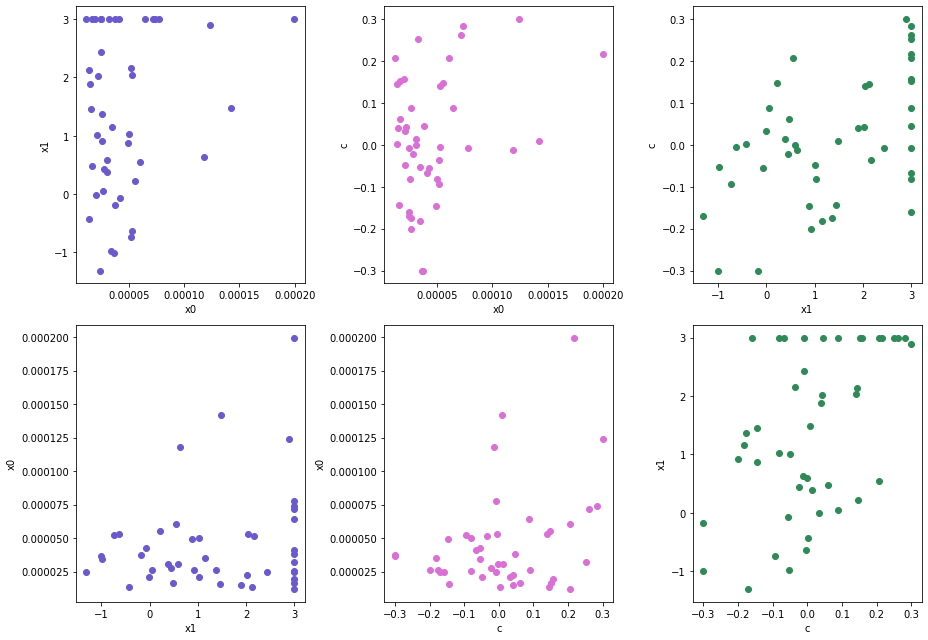

In [111]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(new_fit_x0, new_fit_x1, color='slateblue')
ax[0,0].set_xlabel('x0')
ax[0,0].set_ylabel('x1')

ax[0,1].scatter(new_fit_x0, new_fit_c, color='orchid')
ax[0,1].set_xlabel('x0')
ax[0,1].set_ylabel('c')

ax[0,2].scatter(new_fit_x1, new_fit_c, color='seagreen')
ax[0,2].set_xlabel('x1')
ax[0,2].set_ylabel('c')

ax[1,0].scatter(new_fit_x1, new_fit_x0, color='slateblue')
ax[1,0].set_xlabel('x1')
ax[1,0].set_ylabel('x0')

ax[1,1].scatter(new_fit_c, new_fit_x0, color='orchid')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel('x0')

ax[1,2].scatter(new_fit_c, new_fit_x1, color='seagreen')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel('x1')


fig.tight_layout()
fig.show()

Still not seeing any correlation between parameters

### Converting x1 into $\Delta m_{15B}$

$\Delta m_{15} = 1.09 - 0.161x_{1}+0.013x_{1}^{2}-0.00130x_{1}^{3}$ (From <a href="https://ui.adsabs.harvard.edu/abs/2007A%26A...466...11G/abstract"> Julien Guy's SALT2 paper </a>)

In [161]:
import uncertainties as unc  
import uncertainties.unumpy as unp

x1_with_unc = unp.uarray((new_fit_x1, new_fit_x1e))

/tmp/ipykernel_8564/3875243177.py:4: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  x1_with_unc = unp.uarray((new_fit_x1, new_fit_x1e))


In [162]:
delta_m15b=[]
for i in range(45):
    delta_m15b.append(1.09 - (0.161*(x1_with_unc[i])) + (0.013*(x1_with_unc[i])**2) - (0.00130*(x1_with_unc[i])**3))
delta_m15b_e = unp.std_devs(delta_m15b)
delta_m15b_n = unp.nominal_values(delta_m15b)

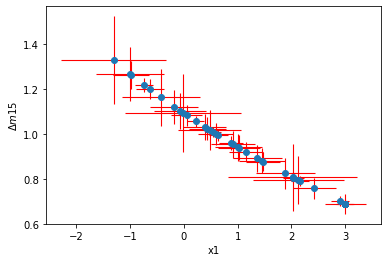

In [163]:
# Look at relationship between x1 and delta m15
# plt.scatter(new_fit_x1,delta_m15_n)
plt.errorbar(new_fit_x1,delta_m15b_n,xerr=new_fit_x1e,yerr=delta_m15b_e, fmt="o", elinewidth=1.1, ecolor="red")
plt.xlabel("x1")
plt.ylabel("$\Delta m15$");

inverse relationship

### Converting x0 into $m_{B}$
$m_{B} = −2.5\log(x_{0})+10.635$ (From <a href="https://arxiv.org/abs/1401.4065"> this paper </a>)

In [166]:
x0_with_unc = unp.uarray((new_fit_x0, new_fit_x0e))

/tmp/ipykernel_8564/3147248892.py:1: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  x0_with_unc = unp.uarray((new_fit_x0, new_fit_x0e))


In [167]:
mb=[]
for i in range(45):
    mb.append((-2.5*unp.log10(x0_with_unc[i]))+10.635)
mb_e = unp.std_devs(mb)
mb_n = unp.nominal_values(mb)

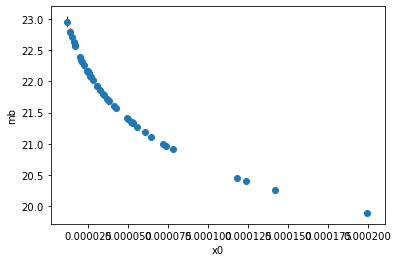

In [168]:
# Look at relationship between x0 and mb
#plt.scatter(new_fit_x0,mb_n)
plt.errorbar(new_fit_x0,mb_n,xerr=new_fit_x0e,yerr=mb_e, fmt="o", elinewidth=1.1, ecolor="red")
plt.xlabel("x0")
plt.ylabel("mb");

### Calculating $\Delta M_{B}$

In [198]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

abs_mag=[]
for i in range(45):
    lum_dist = cosmo.luminosity_distance(new_fit_z[i])
    dist_mod = 5*np.log10(lum_dist.value)+25
    abs_mag.append(mb_n[i]-dist_mod)
print(abs_mag)

[-19.488307088525865, -19.001718779236406, -18.416386125565367, -18.352495432313138, -18.71796735724439, -19.221765154187857, -18.060529913877872, -16.356223593483655, -18.961057668042095, -19.04432993075853, -18.88792370742367, -19.018222510798424, -18.738736939991973, -19.267275871438642, -17.211780058029845, -17.923929224191404, -18.648620409467547, -19.46158860646031, -18.690540237640157, -18.87246071535666, -18.959002666970967, -18.117141438670167, -19.277156013998408, -18.807141350103578, -18.198142367869274, -17.288360531786708, -19.792630436132754, -18.791884934876563, -18.47196788149033, -18.89972697076103, -19.551728600339803, -18.93087527936612, -18.528352217732635, -19.18232434901093, -18.647783325162273, -19.056169646373128, -18.476408029158414, -18.142851269182167, -18.994629998875045, -19.50312841173116, -18.47017801808861, -18.951017588076255, -19.682160360505485, -18.41869076816485, -18.644947526454338]


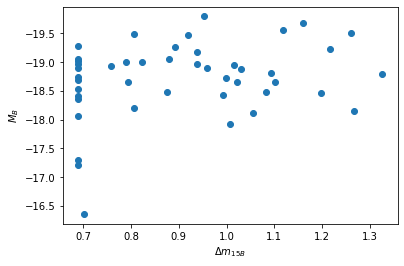

In [199]:
#plt.scatter(delta_m15b_n,abs_mag)
plt.scatter(delta_m15b_n,abs_mag)
# plt.errorbar(delta_m15b_n,abs_mag, xerr=delta_m15b_e, fmt="o", elinewidth=1.1, ecolor="red")
plt.xlabel("$\Delta m_{15B}$")
plt.ylabel("$M_{B}$")
plt.gca().invert_yaxis();

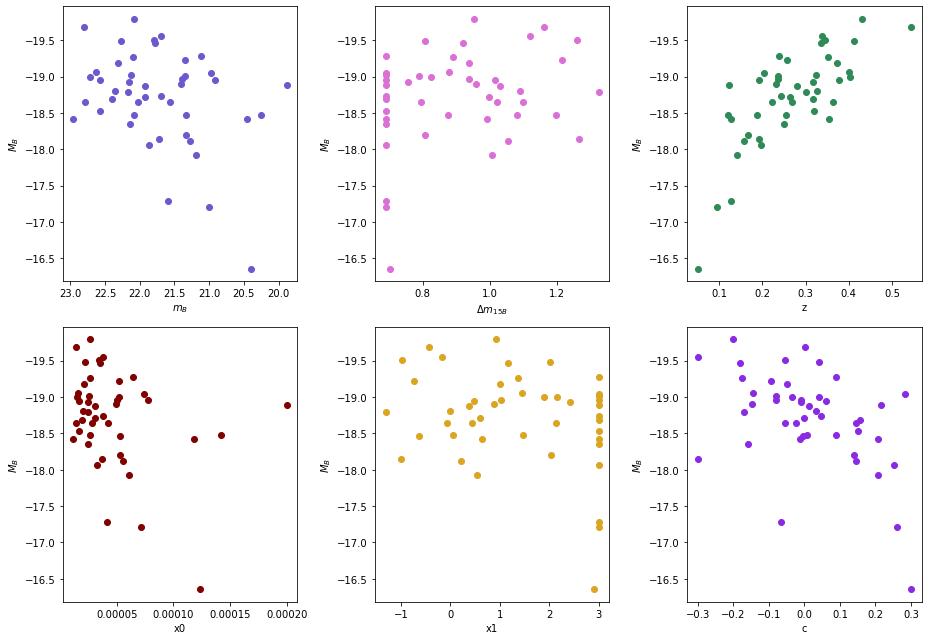

In [197]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(mb_n, abs_mag, color='slateblue')
ax[0,0].set_xlabel("$m_{B}$")
ax[0,0].set_ylabel("$M_{B}$")
ax[0,0].invert_yaxis()
ax[0,0].invert_xaxis()

ax[0,1].scatter(delta_m15b_n, abs_mag, color='orchid')
ax[0,1].set_xlabel("$\Delta m_{15B}$")
ax[0,1].set_ylabel("$M_{B}$")
ax[0,1].invert_yaxis()

ax[0,2].scatter(new_fit_z, abs_mag, color='seagreen')
ax[0,2].set_xlabel('z')
ax[0,2].set_ylabel("$M_{B}$")
ax[0,2].invert_yaxis()

ax[1,0].scatter(new_fit_x0, abs_mag, color='maroon')
ax[1,0].set_xlabel('x0')
ax[1,0].set_ylabel("$M_{B}$")
ax[1,0].invert_yaxis()

ax[1,1].scatter(new_fit_x1, abs_mag, color='goldenrod')
ax[1,1].set_xlabel('x1')
ax[1,1].set_ylabel("$M_{B}$")
ax[1,1].invert_yaxis()

ax[1,2].scatter(new_fit_c, abs_mag, color='blueviolet')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel("$M_{B}$")
ax[1,2].invert_yaxis()

fig.tight_layout()
fig.show();

Negative exponential/logarithmic relationship

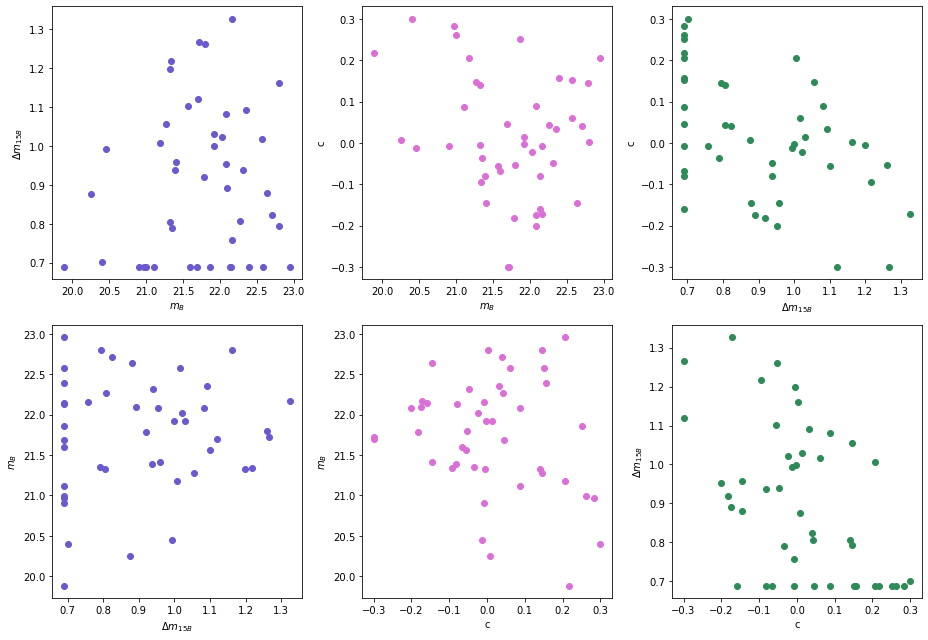

In [157]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(mb_n, delta_m15b_n, color='slateblue')
ax[0,0].set_xlabel("$m_{B}$")
ax[0,0].set_ylabel("$\Delta m_{15B}$")

ax[0,1].scatter(mb_n, new_fit_c, color='orchid')
ax[0,1].set_xlabel("$m_{B}$")
ax[0,1].set_ylabel('c')

ax[0,2].scatter(delta_m15b_n, new_fit_c, color='seagreen')
ax[0,2].set_xlabel("$\Delta m_{15B}$")
ax[0,2].set_ylabel('c')

ax[1,0].scatter(delta_m15b_n, mb_n, color='slateblue')
ax[1,0].set_xlabel("$\Delta m_{15B}$")
ax[1,0].set_ylabel("$m_{B}$")

ax[1,1].scatter(new_fit_c, mb_n, color='orchid')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel("$m_{B}$")

ax[1,2].scatter(new_fit_c, delta_m15b_n, color='seagreen')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel("$\Delta m_{15B}$")


fig.tight_layout()
fig.show()

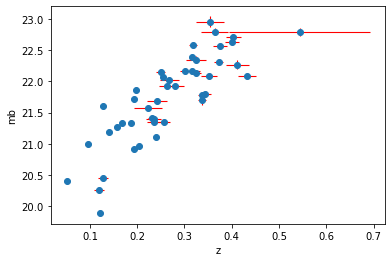

In [119]:
# plt.scatter(new_fit_z, mb)
plt.errorbar(new_fit_z, mb_n, xerr=new_fit_ze, yerr=mb_e, fmt="o",elinewidth=1.1, ecolor="red")
plt.xlabel('z')
plt.ylabel('mb');

In [120]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('AllFits.pdf')

for c in range(45):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')

    # estimate z_range specific to each SNIa
    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

    z_range_offset = 0.1
    z_range = (estimated_redshift-z_range_offset, estimated_redshift+z_range_offset)
    
    # do the fit like the example with sncosmo
    try:
        result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
    except Exception:
        result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':(0.05,0.5),'x1':(-3,3),'c':(-0.3,0.3)})

    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']
    
    sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, model_label=potSNIa_candid[c], fname=pp, format='pdf')

pp.close()